# Bayesian Knowledge Tracing (initial model)

This notebook consists of a baseline BKT model as defined by Corbett & Anderson 1995. BKT aims to track student knowledge states for a given skill using underlying Hidden Markov Models, where the latent states are knowledge of a skill and observed states are correctness in answering questions related to that skill.

Each skill will be represented as a BKT model with 4 parameters:
* $p(L_0)$ or p_init_ : a priori knowledge of the skill (before any practice) 
* $p(T)$ or p_transit : probability of transitioning from the unknown to known state for that concept
* $p(G)$ or p_guess : probability of answering a question correct if the skill is in the unknown state
* $p(S)$ or p_slip : probability of answering a question wrong if the skill is in the known state

And each student will have their own parameter subset $p(L_t)^k$ for each skill $k$ as they answer $t$ questions, which will be updated at each time point (question) $t$ per skill

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import sklearn
from sklearn import metrics
import sys
sys.path.append('../')
from cf_matrix import make_confusion_matrix

## Loading data:

Loading all the dataframes here although I won't be looking at the lectures metadata for this model. Testing data will be used only for assessing model accuracy while training the models will use both the training and questions metadata.

In [2]:
# load data
data_dir = '../data/'

start = time.time()
df_train = pd.read_csv(data_dir + 'train.csv')
print('Training Data Loaded, time elapsed:', round(time.time() - start, 3), 'seconds')
df_lectures = pd.read_csv(data_dir + 'lectures.csv')
df_questions = pd.read_csv(data_dir + 'questions.csv')
#df_test = pd.read_csv(data_dir + 'example_test.csv')

print('All Dataframes Loaded ------------------------------')

FileNotFoundError: [Errno 2] File ../data/train.csv does not exist: '../data/train.csv'

### Viewing initial dataframes

In [6]:
df_train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
101230327,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
101230328,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
101230329,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
101230330,101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True


In [7]:
df_questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


### Cleaning

In [8]:
# dropping unneeded columns from train
dropcols = ['row_id', 'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation']
df_train.drop(dropcols, axis=1, inplace=True)

In [9]:
# since we aren't looking at lectures, I'm restricting training data to exclude lectures (content_type_id = 1)
print('Dropping {} rows...'.format(len(df_train[df_train['content_type_id'] == 1])))
df_train = df_train[df_train['content_type_id'] == 0]

Dropping 1959032 rows...


In [10]:
# can drop content_type_id now because they're all the same value (0)
df_train.drop('content_type_id', axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# dropping bundle_id and part from questions
# bundle_id represents which questions are shown together and may be used for future modifications of the model,
#  but different bundles don't seem to correspond to different tags so I won't use them here
# part corresponds to a higher level type of question ranging rom 1-5 that are too broad for this analysis
dropcols = ['bundle_id', 'part']
df_questions.drop(dropcols, axis=1, inplace=True)

In [12]:
# changing 'tags' column to a list structure so its easier to query later on and setting null value to -1
df_questions['tags'].fillna('-1', inplace=True)
df_questions['tags'] = df_questions['tags'].str.split()

### Viewing cleaned dataframes

In [13]:
df_train

,timestamp,user_id,content_id,user_answer,answered_correctly
0,0,115,5692,3,1
1,56943,115,5716,2,1
2,118363,115,128,0,1
3,131167,115,7860,0,1
4,137965,115,7922,1,1
...,...,...,...,...,...
101230327,428564420,2147482888,3586,0,1
101230328,428585000,2147482888,6341,3,1
101230329,428613475,2147482888,4212,3,1
101230330,428649406,2147482888,6343,1,0


In [14]:
df_questions

,question_id,correct_answer,tags
0,0,0,"[51, 131, 162, 38]"
1,1,1,"[131, 36, 81]"
2,2,0,"[131, 101, 162, 92]"
3,3,0,"[131, 149, 162, 29]"
4,4,3,"[131, 5, 162, 38]"
...,...,...,...
13518,13518,3,[14]
13519,13519,3,[8]
13520,13520,2,[73]
13521,13521,0,[125]


### Splitting train/test sets

This is necessary because the test set given (df_test) does not actually provide the true labels of student answers, thus impossible to get accuracy from. I will split the training set (df_train) into training and testing sets, where the test set will be ~1mil rows (~1% of training), and such a small test set should be fine given the size of training data. Since this is essentially time series calculations, the test set will be comprised of the last rows of each user (randomly select 1-5 rows for each user) rather than randomly splitting the training set.

In [32]:
df_test = pd.DataFrame()
start = time.time()
for i,user in enumerate(df_train['user_id'].unique()):
    df_test = pd.concat([df_test,df_train[df_train['user_id'] == user][-1 - np.random.randint(4):]])
    if i % 10000 == 0:
        print('user {} done.........time elapsed: {} seconds'.format(i, time.time() - start))
        start = time.time()

user 0 done.........time elapsed: 0.48099207878112793 seconds
user 10000 done.........time elapsed: 955.3037340641022 seconds
user 20000 done.........time elapsed: 929.7716600894928 seconds
user 30000 done.........time elapsed: 928.8658649921417 seconds
user 40000 done.........time elapsed: 940.0345618724823 seconds
user 50000 done.........time elapsed: 936.2491569519043 seconds
user 60000 done.........time elapsed: 940.6341998577118 seconds
user 70000 done.........time elapsed: 948.4981298446655 seconds
user 80000 done.........time elapsed: 960.1756911277771 seconds
user 90000 done.........time elapsed: 958.7641141414642 seconds
user 100000 done.........time elapsed: 961.5525588989258 seconds
user 110000 done.........time elapsed: 967.5787811279297 seconds
user 120000 done.........time elapsed: 972.3550961017609 seconds
user 130000 done.........time elapsed: 977.6888949871063 seconds
user 140000 done.........time elapsed: 983.0202059745789 seconds
user 150000 done.........time elapsed

In [33]:
# dropping rows from training set
df_train.drop(df_test.index, inplace=True, axis=0)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
# reset indeces and save to csv file
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

df_train.to_csv('df_train2.0.csv')
df_test.to_csv('df_test2.0.csv')

In [111]:
df_questions

,question_id,correct_answer,tags
0,0,0,"[51, 131, 162, 38]"
1,1,1,"[131, 36, 81]"
2,2,0,"[131, 101, 162, 92]"
3,3,0,"[131, 149, 162, 29]"
4,4,3,"[131, 5, 162, 38]"
...,...,...,...
13518,13518,3,[14]
13519,13519,3,[8]
13520,13520,2,[73]
13521,13521,0,[125]


In [35]:
df_train

,timestamp,user_id,content_id,user_answer,answered_correctly
0,0,115,5692,3,1
1,56943,115,5716,2,1
2,118363,115,128,0,1
3,131167,115,7860,0,1
4,137965,115,7922,1,1
...,...,...,...,...,...
98287376,428466169,2147482888,5591,3,1
98287377,428517313,2147482888,6128,1,1
98287378,428542872,2147482888,6202,2,1
98287379,428564420,2147482888,3586,0,1


In [36]:
df_test

,timestamp,user_id,content_id,user_answer,answered_correctly
0,668090043,115,3363,1,0
1,668090043,115,3365,0,0
2,668090043,115,3364,1,1
3,571323,124,7218,3,0
4,571323,124,7216,0,0
...,...,...,...,...,...
983914,1470571968,2147482216,1177,3,1
983915,1470594073,2147482216,1399,1,1
983916,428613475,2147482888,4212,3,1
983917,428649406,2147482888,6343,1,0


## Fitting skill parameters

There seems to be a few ways in the literature about how one can do this: EM, brute-force search, and conjugate gradient search have all been done. Here, I've chosen to use the **Empirical Probabilities** approach as defined in Hawkins, Heffernan, and Baker 2011, where they shown that this way of initializing the model parameters resulted in statistically significant increase in model performance. 

In this model the skill parameters will not change with training and will remain constant across time and students...future direction will include accounting for student-specific parameters and potentially modifying those parameters as needed for training.

### Computing knowledge sequences

The first step in the empirical probabilities approach to fitting skill parameters is to compute 'knowledge sequences' for each skill for each student. I am treating each separate 'tag' as its own skill, and questions that have multiple tags will count towards the knowledge sequences for all of the tags. 

Additionally for each skill, each student has their own knowledge sequence and all the knowledge sequences for a skill will be used to calculate that skill's BKT parameters

In [37]:
def get_knowledge_sequence(response):
    """
    Given a list of student responses to questions within a skill, this function computes the 
    knowledge sequence defined by Hawkins et al. (2011)
    This function (1) computes all knowledge permuatations of the length of the student's responses, where
    these permutations have the condition that a wrong answer cannot come after a right answer (no forgetting), 
    then (2) matches the responses to the permutation that's most similar and returns that sequence.
    If there is a tie, the average is taken
    
    Parameters
    ----------
    responses: sequence of student's answers to questions (correct/incorrect) as binary sequence
    
    Returns
    -------
    sequence: binary knowledge sequence where change from 0->1 signifies transition to learned state
    
    """
    l = len(response)
    maxs = []
    maxacc = 0
    
    def accuracy(resp, perm):
        """Get accuracy of student response and a given permutation"""
        unit = 1 / l
        acc = 0
        for i in range(l):
            if resp[i] == perm[i]:
                acc += unit
        return acc
    
    for i in range(l+1):
        perm = ([0] * (l-i)) + ([1] * i)
        if accuracy(response, perm) > maxacc:
            maxacc = accuracy(response, perm)
            maxs = [perm]
        elif accuracy(response, perm) == maxacc:
            maxs.append(perm)
    
    if len(maxs) == 1:
        return maxs[0]
    else:
        maxs = np.array(maxs)
        return list(maxs.mean(axis=0))
    

In [38]:
def get_all_sequences(df_train):
    """
    Function to get all of the knowledge sequences given the training data by going through each student
    and recording correctness to answers in each skill (tag), then calls get_knowledge_sequence to compute
    the knowledge sequences for each skill
    
    Params
    -------
    df_train : training dataframe
    
    Returns
    --------
    responses : raw correct/incorrect sequences for each skill
    sequences : dict of knowledge sequences per skill, where keys are a skill and values are a list of 
                knowledge sequences for that skill (1 per student who was tested on the skill)
    """
    print('TOTAL USERS: {}'.format(len(df_train['user_id'].unique())))
    start = time.time()
    
    # construct student responses for each tag
    responses = dict() # correctness (binary) scores
    sequences = dict() # knowledge sequences
    for n,user in enumerate(df_train['user_id'].unique()):

        # for each interaction of this user
        stuseentags = [] # tags that students has a running score for
        for i,row in df_train[df_train['user_id'] == user].sort_values(by='timestamp').iterrows():
            tags = df_questions.loc[df_questions['question_id'] == row['content_id'], 'tags'].values[0]

            for t in tags:
                responses[t] = responses.get(t, []) # initializes a list if its a new tag
                if t not in stuseentags:
                    stuseentags.append(t)
                    responses[t].append([row['answered_correctly']])
                else:
                    responses[t][-1].append(row['answered_correctly'])
                    
        for tag in stuseentags:
            sequences[tag] = sequences.get(tag, [])
            sequences[tag].append(get_knowledge_sequence(responses[tag][-1]))
        
        if n % 50 == 0:
            print('USER {} COMPLETED----------------\tTime Elapsed: {} seconds'.format(n, time.time() - start))
            start = time.time()
            #break
    
    return responses,sequences

### Fitting parameters to each skill

Given the responses and knowledge sequences, I'm going to fit the parameters for each skill using the following equations (as given by Hawkins 2011):

$$p(L_0) = \frac{\sum{K_0}}{|K_0|}$$


$$p(T) = \frac{\sum_{i!=0}{(1-K_{i-1})}K_i}{\sum_{i!=0}{(1-K_{i-1})}}$$


$$p(G) = \frac{\sum_iC_i(1-K_i)}{\sum_i (1-K_i)}$$


$$p(S) = \frac{\sum_i (1-C_i)K_i}{\sum_i K_i}$$

In [40]:
### CALL THIS FUNCTION TO FIT PARAMS, ALL OTHER FUNCS ARE ENCAPSULATED IN HERE ############
###########################################################################################
## DO NOT DO NOT DO NOT CALL THIS FUNCTION AGAIN -- PARAMS ARE STORED IN JSON FILE ######## 
######## FUNCTION MODIFIED TO RANDOML SELECT 10% OF STUDENTS TO FIT PARAMS TO #############
###########################################################################################
def fit_params_EP(df_train, fit_subset):
    """
    Wrapper function to fit parameters, calls all other functions necessary and then computes 4 parameters
    per skill using the Empirical Probabilities method (Hawkins 2011)
    
    Parameters
    ---------
    df_train : training dataframe to work with
    fit_subset : subset of training data to fit parameters to (saving computation) - must be (0.1]
    
    Returns
    --------
    params :  dict where keys are skill tags, values are a dict of the 4 parameters 
                    (p_init, p_transit, p_guess, p_slip)
    """
    
    random_users = []
    for user in df_train['user_id'].unique():
        rand = np.random.rand()
        if rand < fit_subset:
            random_users.append(user)
    df_train = df_train[df_train['user_id'].isin(random_users)]
    
    C, K = get_all_sequences(df_train)
    
    params = dict()
    for key in C.keys():
        p = dict()

        p['p_init'] = sum([i[0] for i in K[key]]) / len(K[key])

        pt_n, pt_d = 0,0
        pg_n, pg_d = 0,0
        ps_n, ps_d = 0,0

        for i in range(len(max(K[key], key=len))):
            for seq in range(len(K[key])):
                if len(K[key][seq]) <= i:
                    continue
                if i > 0:
                    pt_n += (1-K[key][seq][i-1]) * K[key][seq][i]
                    pt_d += (1-K[key][seq][i-1])
                pg_n += C[key][seq][i] * (1-K[key][seq][i])
                pg_d += 1-K[key][seq][i]
                ps_n += (1-C[key][seq][i]) * K[key][seq][i]
                ps_d += K[key][seq][i]

        p['p_transit'] = pt_n / pt_d if pt_d != 0 else 0
        p['p_guess'] = pg_n / pg_d if pg_d != 0 else 0
        p['p_slip'] = ps_n / ps_d if pg_d != 0 else 0

        params[key] = p
    
    return params

In [41]:
# DON'T RUN THIS AGAIN, PARAMS ARE STORED IN JSON FILE LOOK AT CELL BELOW
params = fit_params_EP(df_train, fit_subset = 0.1)

# save params to json
with open('skill_params.json', 'w') as json_file:
    json.dump(params, json_file)

TOTAL USERS: 98674
USER 0 COMPLETED----------------	Time Elapsed: 0.8609552383422852 seconds
USER 50 COMPLETED----------------	Time Elapsed: 21.69304609298706 seconds
USER 100 COMPLETED----------------	Time Elapsed: 8.466467142105103 seconds
USER 150 COMPLETED----------------	Time Elapsed: 7.858684778213501 seconds
USER 200 COMPLETED----------------	Time Elapsed: 12.421921014785767 seconds
USER 250 COMPLETED----------------	Time Elapsed: 9.520145893096924 seconds
USER 300 COMPLETED----------------	Time Elapsed: 9.817832946777344 seconds
USER 350 COMPLETED----------------	Time Elapsed: 5.988971948623657 seconds
USER 400 COMPLETED----------------	Time Elapsed: 6.974249839782715 seconds
USER 450 COMPLETED----------------	Time Elapsed: 4.56501317024231 seconds
USER 500 COMPLETED----------------	Time Elapsed: 12.743934869766235 seconds
USER 550 COMPLETED----------------	Time Elapsed: 9.217548847198486 seconds
USER 600 COMPLETED----------------	Time Elapsed: 5.557308912277222 seconds
USER 65

USER 5400 COMPLETED----------------	Time Elapsed: 19.780582904815674 seconds
USER 5450 COMPLETED----------------	Time Elapsed: 6.373633861541748 seconds
USER 5500 COMPLETED----------------	Time Elapsed: 14.684442043304443 seconds
USER 5550 COMPLETED----------------	Time Elapsed: 5.878988027572632 seconds
USER 5600 COMPLETED----------------	Time Elapsed: 4.353982925415039 seconds
USER 5650 COMPLETED----------------	Time Elapsed: 12.585348844528198 seconds
USER 5700 COMPLETED----------------	Time Elapsed: 6.78955602645874 seconds
USER 5750 COMPLETED----------------	Time Elapsed: 5.6244001388549805 seconds
USER 5800 COMPLETED----------------	Time Elapsed: 11.356452941894531 seconds
USER 5850 COMPLETED----------------	Time Elapsed: 6.689164638519287 seconds
USER 5900 COMPLETED----------------	Time Elapsed: 15.497756004333496 seconds
USER 5950 COMPLETED----------------	Time Elapsed: 12.058413982391357 seconds
USER 6000 COMPLETED----------------	Time Elapsed: 8.140692949295044 seconds
USER 6

USER 10800 COMPLETED----------------	Time Elapsed: 29.263098001480103 seconds
USER 10850 COMPLETED----------------	Time Elapsed: 8.98866319656372 seconds
USER 10900 COMPLETED----------------	Time Elapsed: 5.821846961975098 seconds
USER 10950 COMPLETED----------------	Time Elapsed: 5.884280204772949 seconds
USER 11000 COMPLETED----------------	Time Elapsed: 22.831527948379517 seconds
USER 11050 COMPLETED----------------	Time Elapsed: 7.407956838607788 seconds
USER 11100 COMPLETED----------------	Time Elapsed: 11.62204909324646 seconds
USER 11150 COMPLETED----------------	Time Elapsed: 5.738733768463135 seconds
USER 11200 COMPLETED----------------	Time Elapsed: 12.34138798713684 seconds
USER 11250 COMPLETED----------------	Time Elapsed: 4.650577783584595 seconds
USER 11300 COMPLETED----------------	Time Elapsed: 5.752155065536499 seconds
USER 11350 COMPLETED----------------	Time Elapsed: 21.867870807647705 seconds
USER 11400 COMPLETED----------------	Time Elapsed: 4.83930516242981 second

USER 16150 COMPLETED----------------	Time Elapsed: 5.435224771499634 seconds
USER 16200 COMPLETED----------------	Time Elapsed: 4.5722010135650635 seconds
USER 16250 COMPLETED----------------	Time Elapsed: 12.5604407787323 seconds
USER 16300 COMPLETED----------------	Time Elapsed: 5.06344199180603 seconds
USER 16350 COMPLETED----------------	Time Elapsed: 16.998301029205322 seconds
USER 16400 COMPLETED----------------	Time Elapsed: 9.802855730056763 seconds
USER 16450 COMPLETED----------------	Time Elapsed: 10.857509136199951 seconds
USER 16500 COMPLETED----------------	Time Elapsed: 15.98063325881958 seconds
USER 16550 COMPLETED----------------	Time Elapsed: 5.5781919956207275 seconds
USER 16600 COMPLETED----------------	Time Elapsed: 5.82572603225708 seconds
USER 16650 COMPLETED----------------	Time Elapsed: 9.92516803741455 seconds
USER 16700 COMPLETED----------------	Time Elapsed: 11.030860900878906 seconds
USER 16750 COMPLETED----------------	Time Elapsed: 11.042317152023315 secon

USER 21500 COMPLETED----------------	Time Elapsed: 5.816367149353027 seconds
USER 21550 COMPLETED----------------	Time Elapsed: 7.237174987792969 seconds
USER 21600 COMPLETED----------------	Time Elapsed: 6.030578851699829 seconds
USER 21650 COMPLETED----------------	Time Elapsed: 7.298000812530518 seconds
USER 21700 COMPLETED----------------	Time Elapsed: 8.136065006256104 seconds
USER 21750 COMPLETED----------------	Time Elapsed: 3.799252986907959 seconds
USER 21800 COMPLETED----------------	Time Elapsed: 14.574478149414062 seconds
USER 21850 COMPLETED----------------	Time Elapsed: 23.13449192047119 seconds
USER 21900 COMPLETED----------------	Time Elapsed: 9.326173067092896 seconds
USER 21950 COMPLETED----------------	Time Elapsed: 13.934154987335205 seconds
USER 22000 COMPLETED----------------	Time Elapsed: 5.366255044937134 seconds
USER 22050 COMPLETED----------------	Time Elapsed: 8.528450012207031 seconds
USER 22100 COMPLETED----------------	Time Elapsed: 6.0889410972595215 seco

USER 26850 COMPLETED----------------	Time Elapsed: 8.539357900619507 seconds
USER 26900 COMPLETED----------------	Time Elapsed: 3.874729871749878 seconds
USER 26950 COMPLETED----------------	Time Elapsed: 5.259597063064575 seconds
USER 27000 COMPLETED----------------	Time Elapsed: 10.16409182548523 seconds
USER 27050 COMPLETED----------------	Time Elapsed: 9.8067626953125 seconds
USER 27100 COMPLETED----------------	Time Elapsed: 33.726011991500854 seconds
USER 27150 COMPLETED----------------	Time Elapsed: 5.2505998611450195 seconds
USER 27200 COMPLETED----------------	Time Elapsed: 5.831594944000244 seconds
USER 27250 COMPLETED----------------	Time Elapsed: 7.8350160121917725 seconds
USER 27300 COMPLETED----------------	Time Elapsed: 4.17686915397644 seconds
USER 27350 COMPLETED----------------	Time Elapsed: 5.659124851226807 seconds
USER 27400 COMPLETED----------------	Time Elapsed: 13.289446115493774 seconds
USER 27450 COMPLETED----------------	Time Elapsed: 6.76360011100769 seconds

USER 32200 COMPLETED----------------	Time Elapsed: 6.5002522468566895 seconds
USER 32250 COMPLETED----------------	Time Elapsed: 5.284487724304199 seconds
USER 32300 COMPLETED----------------	Time Elapsed: 10.804264783859253 seconds
USER 32350 COMPLETED----------------	Time Elapsed: 12.423818826675415 seconds
USER 32400 COMPLETED----------------	Time Elapsed: 12.861417770385742 seconds
USER 32450 COMPLETED----------------	Time Elapsed: 9.802197217941284 seconds
USER 32500 COMPLETED----------------	Time Elapsed: 5.484864950180054 seconds
USER 32550 COMPLETED----------------	Time Elapsed: 5.838908910751343 seconds
USER 32600 COMPLETED----------------	Time Elapsed: 10.114141941070557 seconds
USER 32650 COMPLETED----------------	Time Elapsed: 6.69690203666687 seconds
USER 32700 COMPLETED----------------	Time Elapsed: 4.905407905578613 seconds
USER 32750 COMPLETED----------------	Time Elapsed: 6.2406370639801025 seconds
USER 32800 COMPLETED----------------	Time Elapsed: 6.924476146697998 se

USER 37550 COMPLETED----------------	Time Elapsed: 7.4812071323394775 seconds
USER 37600 COMPLETED----------------	Time Elapsed: 5.545236110687256 seconds
USER 37650 COMPLETED----------------	Time Elapsed: 9.690485000610352 seconds
USER 37700 COMPLETED----------------	Time Elapsed: 9.151674032211304 seconds
USER 37750 COMPLETED----------------	Time Elapsed: 4.606782913208008 seconds
USER 37800 COMPLETED----------------	Time Elapsed: 5.2083001136779785 seconds
USER 37850 COMPLETED----------------	Time Elapsed: 8.131568193435669 seconds
USER 37900 COMPLETED----------------	Time Elapsed: 16.318578958511353 seconds
USER 37950 COMPLETED----------------	Time Elapsed: 5.269971132278442 seconds
USER 38000 COMPLETED----------------	Time Elapsed: 12.447529077529907 seconds
USER 38050 COMPLETED----------------	Time Elapsed: 6.254061937332153 seconds
USER 38100 COMPLETED----------------	Time Elapsed: 4.908534049987793 seconds
USER 38150 COMPLETED----------------	Time Elapsed: 2.777388095855713 sec

USER 42900 COMPLETED----------------	Time Elapsed: 5.745173931121826 seconds
USER 42950 COMPLETED----------------	Time Elapsed: 8.981271028518677 seconds
USER 43000 COMPLETED----------------	Time Elapsed: 8.381518125534058 seconds
USER 43050 COMPLETED----------------	Time Elapsed: 2.819650888442993 seconds
USER 43100 COMPLETED----------------	Time Elapsed: 6.89199686050415 seconds
USER 43150 COMPLETED----------------	Time Elapsed: 4.395056962966919 seconds
USER 43200 COMPLETED----------------	Time Elapsed: 10.173730850219727 seconds
USER 43250 COMPLETED----------------	Time Elapsed: 4.857203960418701 seconds
USER 43300 COMPLETED----------------	Time Elapsed: 8.623396158218384 seconds
USER 43350 COMPLETED----------------	Time Elapsed: 6.22261905670166 seconds
USER 43400 COMPLETED----------------	Time Elapsed: 12.38906717300415 seconds
USER 43450 COMPLETED----------------	Time Elapsed: 10.957659006118774 seconds
USER 43500 COMPLETED----------------	Time Elapsed: 5.6401450634002686 second

USER 48200 COMPLETED----------------	Time Elapsed: 6.29750919342041 seconds
USER 48250 COMPLETED----------------	Time Elapsed: 8.655915021896362 seconds
USER 48300 COMPLETED----------------	Time Elapsed: 8.219985008239746 seconds
USER 48350 COMPLETED----------------	Time Elapsed: 13.771641969680786 seconds
USER 48400 COMPLETED----------------	Time Elapsed: 6.44530987739563 seconds
USER 48450 COMPLETED----------------	Time Elapsed: 6.573096036911011 seconds
USER 48500 COMPLETED----------------	Time Elapsed: 8.432393074035645 seconds
USER 48550 COMPLETED----------------	Time Elapsed: 11.674679040908813 seconds
USER 48600 COMPLETED----------------	Time Elapsed: 8.047598123550415 seconds
USER 48650 COMPLETED----------------	Time Elapsed: 8.499686002731323 seconds
USER 48700 COMPLETED----------------	Time Elapsed: 34.31577801704407 seconds
USER 48750 COMPLETED----------------	Time Elapsed: 9.783623933792114 seconds
USER 48800 COMPLETED----------------	Time Elapsed: 6.234158992767334 seconds

USER 53550 COMPLETED----------------	Time Elapsed: 4.344192981719971 seconds
USER 53600 COMPLETED----------------	Time Elapsed: 4.175276041030884 seconds
USER 53650 COMPLETED----------------	Time Elapsed: 13.04793906211853 seconds
USER 53700 COMPLETED----------------	Time Elapsed: 9.226122856140137 seconds
USER 53750 COMPLETED----------------	Time Elapsed: 9.332699060440063 seconds
USER 53800 COMPLETED----------------	Time Elapsed: 13.628539800643921 seconds
USER 53850 COMPLETED----------------	Time Elapsed: 7.797171354293823 seconds
USER 53900 COMPLETED----------------	Time Elapsed: 7.4298927783966064 seconds
USER 53950 COMPLETED----------------	Time Elapsed: 19.98221492767334 seconds
USER 54000 COMPLETED----------------	Time Elapsed: 5.351446151733398 seconds
USER 54050 COMPLETED----------------	Time Elapsed: 7.282918214797974 seconds
USER 54100 COMPLETED----------------	Time Elapsed: 9.450620174407959 seconds
USER 54150 COMPLETED----------------	Time Elapsed: 5.603307008743286 secon

USER 58900 COMPLETED----------------	Time Elapsed: 10.22278094291687 seconds
USER 58950 COMPLETED----------------	Time Elapsed: 4.27292275428772 seconds
USER 59000 COMPLETED----------------	Time Elapsed: 6.4900078773498535 seconds
USER 59050 COMPLETED----------------	Time Elapsed: 10.07780933380127 seconds
USER 59100 COMPLETED----------------	Time Elapsed: 17.453049898147583 seconds
USER 59150 COMPLETED----------------	Time Elapsed: 6.4874958992004395 seconds
USER 59200 COMPLETED----------------	Time Elapsed: 17.948819875717163 seconds
USER 59250 COMPLETED----------------	Time Elapsed: 9.691792011260986 seconds
USER 59300 COMPLETED----------------	Time Elapsed: 11.308909893035889 seconds
USER 59350 COMPLETED----------------	Time Elapsed: 17.75545597076416 seconds
USER 59400 COMPLETED----------------	Time Elapsed: 5.089664936065674 seconds
USER 59450 COMPLETED----------------	Time Elapsed: 8.451235055923462 seconds
USER 59500 COMPLETED----------------	Time Elapsed: 5.54132080078125 seco

USER 64250 COMPLETED----------------	Time Elapsed: 14.039359092712402 seconds
USER 64300 COMPLETED----------------	Time Elapsed: 7.479674816131592 seconds
USER 64350 COMPLETED----------------	Time Elapsed: 4.318540096282959 seconds
USER 64400 COMPLETED----------------	Time Elapsed: 3.5210139751434326 seconds
USER 64450 COMPLETED----------------	Time Elapsed: 7.211625099182129 seconds
USER 64500 COMPLETED----------------	Time Elapsed: 9.29281497001648 seconds
USER 64550 COMPLETED----------------	Time Elapsed: 5.337587118148804 seconds
USER 64600 COMPLETED----------------	Time Elapsed: 10.724987268447876 seconds
USER 64650 COMPLETED----------------	Time Elapsed: 6.138077259063721 seconds
USER 64700 COMPLETED----------------	Time Elapsed: 17.649492025375366 seconds
USER 64750 COMPLETED----------------	Time Elapsed: 4.820515871047974 seconds
USER 64800 COMPLETED----------------	Time Elapsed: 14.986265182495117 seconds
USER 64850 COMPLETED----------------	Time Elapsed: 27.600018978118896 se

USER 69550 COMPLETED----------------	Time Elapsed: 5.355388879776001 seconds
USER 69600 COMPLETED----------------	Time Elapsed: 4.633953094482422 seconds
USER 69650 COMPLETED----------------	Time Elapsed: 4.533743858337402 seconds
USER 69700 COMPLETED----------------	Time Elapsed: 7.106629133224487 seconds
USER 69750 COMPLETED----------------	Time Elapsed: 10.872300148010254 seconds
USER 69800 COMPLETED----------------	Time Elapsed: 3.0826549530029297 seconds
USER 69850 COMPLETED----------------	Time Elapsed: 9.6527738571167 seconds
USER 69900 COMPLETED----------------	Time Elapsed: 8.50813889503479 seconds
USER 69950 COMPLETED----------------	Time Elapsed: 11.35993218421936 seconds
USER 70000 COMPLETED----------------	Time Elapsed: 5.713374853134155 seconds
USER 70050 COMPLETED----------------	Time Elapsed: 6.444056034088135 seconds
USER 70100 COMPLETED----------------	Time Elapsed: 8.173897981643677 seconds
USER 70150 COMPLETED----------------	Time Elapsed: 4.9327781200408936 seconds

USER 74900 COMPLETED----------------	Time Elapsed: 8.857419967651367 seconds
USER 74950 COMPLETED----------------	Time Elapsed: 6.743582010269165 seconds
USER 75000 COMPLETED----------------	Time Elapsed: 10.733464002609253 seconds
USER 75050 COMPLETED----------------	Time Elapsed: 6.042970895767212 seconds
USER 75100 COMPLETED----------------	Time Elapsed: 4.4566810131073 seconds
USER 75150 COMPLETED----------------	Time Elapsed: 12.08524489402771 seconds
USER 75200 COMPLETED----------------	Time Elapsed: 5.428030014038086 seconds
USER 75250 COMPLETED----------------	Time Elapsed: 14.06717586517334 seconds
USER 75300 COMPLETED----------------	Time Elapsed: 11.864652872085571 seconds
USER 75350 COMPLETED----------------	Time Elapsed: 30.23210120201111 seconds
USER 75400 COMPLETED----------------	Time Elapsed: 15.955719947814941 seconds
USER 75450 COMPLETED----------------	Time Elapsed: 15.885896921157837 seconds
USER 75500 COMPLETED----------------	Time Elapsed: 12.695036888122559 seco

USER 80250 COMPLETED----------------	Time Elapsed: 3.7849740982055664 seconds
USER 80300 COMPLETED----------------	Time Elapsed: 12.90060806274414 seconds
USER 80350 COMPLETED----------------	Time Elapsed: 4.557597398757935 seconds
USER 80400 COMPLETED----------------	Time Elapsed: 8.181848049163818 seconds
USER 80450 COMPLETED----------------	Time Elapsed: 6.6461381912231445 seconds
USER 80500 COMPLETED----------------	Time Elapsed: 7.145779371261597 seconds
USER 80550 COMPLETED----------------	Time Elapsed: 6.3171470165252686 seconds
USER 80600 COMPLETED----------------	Time Elapsed: 6.027706861495972 seconds
USER 80650 COMPLETED----------------	Time Elapsed: 4.766867160797119 seconds
USER 80700 COMPLETED----------------	Time Elapsed: 10.186794996261597 seconds
USER 80750 COMPLETED----------------	Time Elapsed: 7.749590158462524 seconds
USER 80800 COMPLETED----------------	Time Elapsed: 6.8425140380859375 seconds
USER 80850 COMPLETED----------------	Time Elapsed: 5.709712266921997 se

USER 85600 COMPLETED----------------	Time Elapsed: 4.56857705116272 seconds
USER 85650 COMPLETED----------------	Time Elapsed: 9.097301006317139 seconds
USER 85700 COMPLETED----------------	Time Elapsed: 7.10501503944397 seconds
USER 85750 COMPLETED----------------	Time Elapsed: 19.766144037246704 seconds
USER 85800 COMPLETED----------------	Time Elapsed: 5.855122089385986 seconds
USER 85850 COMPLETED----------------	Time Elapsed: 6.272431135177612 seconds
USER 85900 COMPLETED----------------	Time Elapsed: 7.789549112319946 seconds
USER 85950 COMPLETED----------------	Time Elapsed: 8.66641116142273 seconds
USER 86000 COMPLETED----------------	Time Elapsed: 4.832412242889404 seconds
USER 86050 COMPLETED----------------	Time Elapsed: 6.967894077301025 seconds
USER 86100 COMPLETED----------------	Time Elapsed: 10.21599292755127 seconds
USER 86150 COMPLETED----------------	Time Elapsed: 6.087592840194702 seconds
USER 86200 COMPLETED----------------	Time Elapsed: 5.020953893661499 seconds
U

USER 90950 COMPLETED----------------	Time Elapsed: 9.232528924942017 seconds
USER 91000 COMPLETED----------------	Time Elapsed: 5.8647449016571045 seconds
USER 91050 COMPLETED----------------	Time Elapsed: 32.13045310974121 seconds
USER 91100 COMPLETED----------------	Time Elapsed: 7.169885873794556 seconds
USER 91150 COMPLETED----------------	Time Elapsed: 4.694293975830078 seconds
USER 91200 COMPLETED----------------	Time Elapsed: 5.713465690612793 seconds
USER 91250 COMPLETED----------------	Time Elapsed: 9.83250617980957 seconds
USER 91300 COMPLETED----------------	Time Elapsed: 10.360830068588257 seconds
USER 91350 COMPLETED----------------	Time Elapsed: 6.540396213531494 seconds
USER 91400 COMPLETED----------------	Time Elapsed: 6.711772918701172 seconds
USER 91450 COMPLETED----------------	Time Elapsed: 10.811084032058716 seconds
USER 91500 COMPLETED----------------	Time Elapsed: 4.454782009124756 seconds
USER 91550 COMPLETED----------------	Time Elapsed: 9.287321090698242 secon

USER 96300 COMPLETED----------------	Time Elapsed: 9.519840955734253 seconds
USER 96350 COMPLETED----------------	Time Elapsed: 8.653976917266846 seconds
USER 96400 COMPLETED----------------	Time Elapsed: 7.706801891326904 seconds
USER 96450 COMPLETED----------------	Time Elapsed: 7.365599870681763 seconds
USER 96500 COMPLETED----------------	Time Elapsed: 4.887778997421265 seconds
USER 96550 COMPLETED----------------	Time Elapsed: 10.307008028030396 seconds
USER 96600 COMPLETED----------------	Time Elapsed: 7.368854999542236 seconds
USER 96650 COMPLETED----------------	Time Elapsed: 10.5730299949646 seconds
USER 96700 COMPLETED----------------	Time Elapsed: 8.551643133163452 seconds
USER 96750 COMPLETED----------------	Time Elapsed: 4.661375045776367 seconds
USER 96800 COMPLETED----------------	Time Elapsed: 6.172899007797241 seconds
USER 96850 COMPLETED----------------	Time Elapsed: 10.550962209701538 seconds
USER 96900 COMPLETED----------------	Time Elapsed: 6.171365022659302 second

In [ ]:
# to get the skill parameters
f = open('skill_params.json')
params = json.load(f)

### Looking at parameter distributions

In [47]:
df_params = pd.DataFrame(params).T
df_params.drop('-1', inplace=True)
df_params

,p_init,p_transit,p_guess,p_slip
131,0.721816,0.266157,0.283920,0.173870
93,0.770456,0.510148,0.149957,0.089715
81,0.549010,0.148939,0.358141,0.262111
10,0.327621,0.255193,0.227717,0.224273
94,0.377834,0.358519,0.122535,0.153673
...,...,...,...,...
139,0.631673,0.402746,0.257155,0.125458
11,0.258517,0.241626,0.223282,0.216444
59,0.443121,0.360506,0.235307,0.165463
86,0.572785,0.616438,0.008499,0.005906


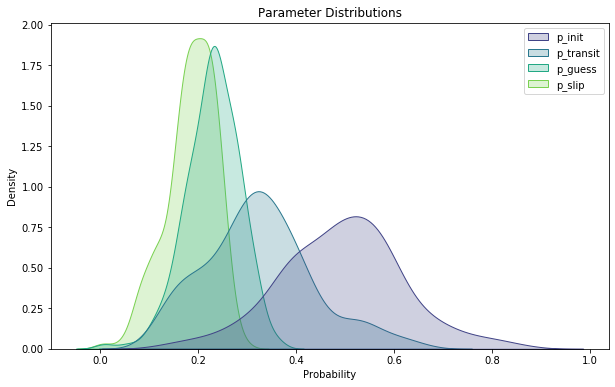

In [54]:
# viz param dist
plt.figure(figsize=(10,6))
sns.kdeplot(data=df_params, fill=True, palette='viridis')
plt.xlabel('Probability')
plt.title('Parameter Distributions')
plt.show()

In [51]:
# checking for model degeneracy
np.where((df_params['p_guess'] >= 0.5)| (df_params['p_slip'] >= 0.5))

(array([], dtype=int64),)

No model degenarcy (CHECK / RUN AGAIN) which is good, graph shows same pattern and initial learning is pretty normally distributed around 50% across the skills, p_transit is a little lower

In [52]:
df_params.describe()

,p_init,p_transit,p_guess,p_slip
count,188.000000,188.000000,188.000000,188.000000
mean,0.492763,0.322921,0.229220,0.185525
std,0.124920,0.110086,0.054885,0.050220
min,0.134969,0.113345,0.008499,0.005906
25%,0.409111,0.257314,0.195770,0.159013
50%,0.499019,0.319682,0.231576,0.190448
75%,0.569397,0.387780,0.268905,0.224276
max,0.854836,0.643376,0.358141,0.291610


## Training the Model

In training the model, each student's learning for each skill is tracked and updated as new observable states come in. This will allow for the skill-specific parameters to be tested and for correctness of a skill for a given student to be predicted as well.

Updating student skill parameters $p(L_t)^k_u$ representing the probability of skill mastery for skill $k$ and student $u$ at observation $t$ in the skill is as follows:

(1) $$p(L_1)^k_u = p(L_0)^k$$


(2) $$p(L_{t+1} | obs = correct)^k_u = \frac{p(L_t)^k_u \cdot (1 - p(S)^k)}{p(L_t)^k_u \cdot (1 - p(S)^k) + (1 - p(L_t)^k_u) \cdot p(G)^k}$$


(3) $$p(L_{t+1} | obs = wrong)^k_u = \frac{p(L_t)^k_u \cdot p(S)^k}{p(L_t)^k_u \cdot p(S)^k + (1 - p(L_t)^k_u) \cdot (1 - p(G)^k)}$$


(4) $$p(L_{t+1})^k_u = p(L_{t+1} | obs)^k_u + (1 - p(L_{t+1} | obs)^k_u) \cdot p(T)^k$$


(5) $$p(C_{t+1})^k_u = p(L_t)^k_u \cdot (1 - p(S)^k) + (1 - p(L_t)^k_u) \cdot p(G)^k$$


Where equation (1) is used as the a priori knowledge of a skill, equations (2) and (3) are conditional probabilities of student mastery of the skill given their answer (correct/incorrect) to a question of that skill, equation (4) is used to update the probability of student mastery of that skill, and equation (5) is for predictions of how the student will perform on subsequent questions within that skill

In [18]:
class BKTModel:
    
    def __init__(self, skill_params, q_tags):
        self.skill_params = skill_params
        self.users = dict() # form: {user_id : {skill: .1, skill2: .9, etc}}
        self.questions = q_tags
    
    # eq 1
    def get_prior(self, skill):
        return self.skill_params[skill]['p_init']
    
    def get_user_skill(self, user, skill):
        """
        Gets the p(L) of a user for given skill, initializes the user/skill if not already in self.users
        """
        if user not in self.users.keys():
            self.users[user] = dict()
        if skill not in self.users[user]:
            self.users[user][skill] = self.get_prior(skill)
        return self.users[user][skill]
    
    def train(self, df):
        """
        To train the model 
        
        parameters
        ----------
        df : pandas dataframe of training data where each row corresponds to an event/observation
        """
        # helper functions corresponding to above equations
        # eq 2
        def cond_correct(user, skill):
            pL = self.get_user_skill(user, skill)
            top = pL * (1 - self.skill_params[skill]['p_slip'])
            bottom = top + ((1 - pL) * self.skill_params[skill]['p_guess'])
            return top / bottom
        # eq 3
        def cond_wrong(user, skill):
            pL = self.get_user_skill(user, skill)
            top = pL * self.skill_params[skill]['p_slip']
            bottom = top + ((1 - pL) * (1 - self.skill_params[skill]['p_guess']))
            return top / bottom
        # eq 4, calls 2 or 3
        # 'correct' is bool (0=false/1=true)
        def update_knowledge(user, skill, correct):
            if correct:
                cond_pL = cond_correct(user, skill)
            else:
                cond_pL = cond_wrong(user, skill)
            self.users[user][skill] = cond_pL + ((1 - cond_pL) * self.skill_params[skill]['p_transit'])
            
        # main training loop
        print('BEGINNING TRAINING --------------------------------------------------------------')
        start = time.time()
        for i,row in df.iterrows():
            tags = self.questions[row['content_id']]
            for tag in tags:
                if tag == '-1':
                    continue
                update_knowledge(row['user_id'], tag, row['answered_correctly'])
            
            if i % 1000000 == 0:
                print('Iteration {} done -------------------- Time elapsed: {} seconds'.format(i, time.time() - start))
                start = time.time()
                
    # eq 5
    def predict(self, user, skill):
        """
        Function to predict correctness of a single user to answering a question within a skill
        """
        pL = self.get_user_skill(user, skill)
        return (pL * (1 - self.skill_params[skill]['p_slip'])) + ((1 - pL) * self.skill_params[skill]['p_guess'])
    
    def test(self, df, cutoff, confusion_mat=True, raw_probs=True):
        """
        Function to run predictions on testing data. 
        If a question has multiple tags then I take the average of those predictions
        
        parameters
        ----------
        df : pandas dataframe with testing data, must be in format where 1 row = 1 observation
        cutoff : cutoff probability to be marked as correct (ie if 0.5 then everything >= 0.5 = correct)
        confusion_mat : whether to return a confusion matrix plot, default True
        raw_probs : whether to return the raw probabilities (before casting to 0/1 based on cutoff), default True
        
        returns
        --------
        df_test : test dataframe with predicted correct/incorrect column
                    also includes raw_probability column if param is True
        accuracy : computed accuracy
        confusion : confusion matrix visualization
        """
        
        predicted = []
        raw_probability = []
        for i,row in df.iterrows():
            tags = self.questions[row['content_id']]
            tot = 0
            for tag in tags:
                tot += self.predict(row['user_id'], tag)
            raw_probability.append(tot / len(tags))
            predicted.append(int((tot/len(tags)) > cutoff))
        
        df_test = df.copy()
        df_test['predicted'] = predicted
        if raw_probs:
            df_test['raw_probability'] = raw_probability
        accuracy = sklearn.metrics.accuracy_score(df_test['answered_correctly'].values, predicted)
        
        if confusion_mat:
            confusion = sklearn.metrics.confusion_matrix(df_test['answered_correctly'].values, predicted)
            categories = ['incorrect', 'correct']
            confusion_viz = make_confusion_matrix(confusion, categories=categories)
            return df_test, accuracy, confusion_viz
        return df_test, accuracy

In [58]:
# initialize model
q_tags = dict(zip(df_questions['question_id'], df_questions['tags']))
params = params
BKT = BKTModel(params, q_tags)

In [ ]:
# ONLY RUN ONCE AND SAVE DATA
BKT.train(df_train)

# save user params
# SPLIT INTO MULTIPLE WHEN SAVING OR EVERYTHING WILL GO TO HELL AND CRASH LIKE LAST TIME AND YOULL HAVE TO RETYPE EVERYTHING
with open('users_trained.json', 'w') as json_file:
    json.dump(BKT.users, json_file)

In [59]:
# get user parameters again (PROB NEED TO CHANGE FOR MULTIPLE FILES)
f = open('users_trained.json')
BKT.users = json.load(f)

In [ ]:
# # SPLITTING INTO MULTIPLE FILES FOR UPLOAD
# for i,(k,v) in enumerate(BKT.users.item()):
#     if i % 59531 == 0:
#         if i != 0:
#             with open(name, 'w') as json_file:
#                 json.dump(group, json_file)
#             print('{} done'.format(i/59531))
#         group = dict()
#         name = 'users_trained_{}.json'.format(int(i/59531))
#     group[k] = v
# with open(name, 'w') as json_file:
#     json.dump(group, json_file)

## Testing predictions

I kind of miscalculated here and df_test doesn't have the true labels so I can't actually use that ... Instead I'll randomly choose 1% of training users to test on (those users' last row/observation in training)

In [61]:
df_test

,timestamp,user_id,content_id,user_answer,answered_correctly
0,668090043,115,3363,1,0
1,668090043,115,3365,0,0
2,668090043,115,3364,1,1
3,571323,124,7218,3,0
4,571323,124,7216,0,0
...,...,...,...,...,...
983914,1470571968,2147482216,1177,3,1
983915,1470594073,2147482216,1399,1,1
983916,428613475,2147482888,4212,3,1
983917,428649406,2147482888,6343,1,0


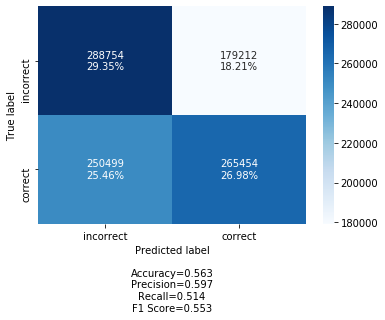

In [151]:
df_results, acc, confusion = BKT.test(df_test, cutoff=0.5)

In [152]:
print(acc)

0.5632658785936647


In [153]:
df_results

,timestamp,user_id,content_id,user_answer,answered_correctly,predicted,raw_probability
0,668090043,115,3363,1,0,0,0.374427
1,668090043,115,3365,0,0,0,0.376048
2,668090043,115,3364,1,1,0,0.376048
3,571323,124,7218,3,0,0,0.443668
4,571323,124,7216,0,0,0,0.407358
...,...,...,...,...,...,...,...
983914,1470571968,2147482216,1177,3,1,1,0.535790
983915,1470594073,2147482216,1399,1,1,1,0.541396
983916,428613475,2147482888,4212,3,1,1,0.585790
983917,428649406,2147482888,6343,1,0,1,0.512390


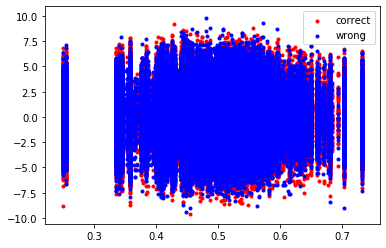

In [154]:
# pred correct/incorrect distributions
pred_correct = df_results[df_results['answered_correctly'] == df_results['predicted']]
pred_wrong = df_results[df_results['answered_correctly'] != df_results['predicted']]

plt.scatter(pred_correct['raw_probability'].values, np.random.normal(0,2,len(pred_correct)), marker='.', color='r', label='correct')
plt.scatter(pred_wrong['raw_probability'].values, np.random.normal(0,2,len(pred_wrong)), marker='.', color='b', label='wrong')
plt.legend()
plt.show()

In [155]:
corr = []
for i,row in df_results.iterrows():
    if row['answered_correctly'] == row['predicted']:
        corr.append('correct')
    else:
        corr.append('incorrect')
df_results['outcome'] = corr

<Figure size 1440x1080 with 0 Axes>

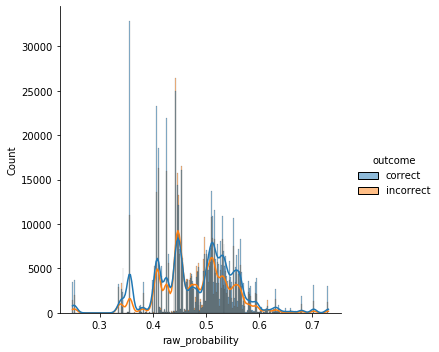

In [156]:
plt.figure(figsize=(20,15))
sns.displot(data=df_results, x='raw_probability', hue='outcome', kde=True)
plt.show()

In [157]:
print('Mean probabilities predicted correct: {}'.format(pred_correct['raw_probability'].mean()))
print('Mean probabilities predicted wrong: {}'.format(pred_wrong['raw_probability'].mean()))

Mean probabilities predicted correct: 0.4816950346305947
Mean probabilities predicted wrong: 0.4802677765449468


In [158]:
sklearn.metrics.roc_auc_score(df_results['answered_correctly'], df_results['predicted'])

0.565766576680195

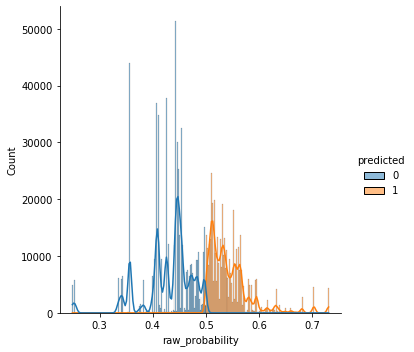

In [159]:
sns.displot(data=df_results, x='raw_probability', hue='predicted', kde=True)
plt.show()

## Error Analysis

Model is barely above chance prediction, which isn't ideal and suggests that I need to incorporate student-specific parameters to the model, since students don't generally have the same pattern of learning and it is difficult to generalize based solely on skills.

However I will still be keeping skill-parameters so that new users can be generalized and overall skill mastery can be modeled in some way, but individual student learning parameters will mostly likely be:
1. skill-specific 
2. updated during training based on performance
3. used as an adjustment to the overall skill parameter updating rules

In [160]:
df_results['user_id'].unique()[:10]

array([  115,   124,  2746,  5382,  8623,  8701, 12741, 13134, 24418,
       24600])

In [161]:
df_results[df_results['user_id'] == 12741]

,timestamp,user_id,content_id,user_answer,answered_correctly,predicted,raw_probability,outcome
16,4465043002,12741,11871,0,1,0,0.477466,incorrect
17,4465043002,12741,11870,3,1,0,0.477466,incorrect
18,4465043002,12741,11869,2,1,0,0.491644,incorrect


In [162]:
df_questions[df_questions['question_id'].isin([3363,3365,3364])]

,question_id,correct_answer,tags
3363,3363,3,"[74, 103, 29]"
3364,3364,1,"[136, 103, 29]"
3365,3365,2,"[136, 103, 29]"


In [163]:
BKT.users['115']

{'151': 0.8490045558731218,
 '168': 0.9135263749213914,
 '131': 0.9999999990811441,
 '149': 0.9967953822021045,
 '92': 0.9993516476070308,
 '104': 0.9133708917789165,
 '81': 0.9916784467401681,
 '101': 0.9951165606754138,
 '162': 0.9925417611792486,
 '38': 0.8823232253780784,
 '187': 0.9983827252220514,
 '68': 0.9907719389919651,
 '5': 0.7133632147227984,
 '93': 0.9999771530037181,
 '130': 0.99880526243679,
 '9': 0.9602385777284427,
 '10': 0.9987919666863988,
 '61': 0.5349611417276371,
 '110': 0.5349611417276371,
 '29': 0.997715450467115,
 '178': 0.9260412557089926,
 '164': 0.811532204418178,
 '111': 0.656330124043763,
 '36': 0.9574880846865735,
 '94': 0.987175902693836,
 '99': 0.9401277732288555,
 '51': 0.9949927345546321,
 '102': 0.7038050572608598,
 '143': 0.779304291213798,
 '140': 0.914310693458053,
 '136': 0.32685995191436995,
 '157': 0.8219034528598332}

In [164]:
BKT.skill_params['136'], BKT.skill_params['103'], BKT.skill_params['29']

({'p_init': 0.16796037424919424,
  'p_transit': 0.1381695155534313,
  'p_guess': 0.2632071731056829,
  'p_slip': 0.24933303010896116},
 {'p_init': 0.1888911741358144,
  'p_transit': 0.1965345877002895,
  'p_guess': 0.2046467877572032,
  'p_slip': 0.2070628671410787},
 {'p_init': 0.35699497020077076,
  'p_transit': 0.16663254410935174,
  'p_guess': 0.30786117982970773,
  'p_slip': 0.24554409533690885})

In [18]:
(1 * .46) / ((1* .46)+ (0*.8))

1.0